In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Flatten
from keras.initializers import Constant
from keras.optimizers import Adam
from spellchecker import SpellChecker
import re
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gohw\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gohw\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Data Cleaning

In [2]:
df = pd.read_csv('train.csv')

In [3]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]

In [4]:
df.loc[df['id'].isin(ids_with_target_error),'target'] = 0

In [5]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [6]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [7]:
def remove_emoji(text):
    emoji = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji.sub(r'', text)

In [8]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [9]:
def correct_spelling(text):
    corrected_text = []
    misspelled_words = SpellChecker().unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(SpellChecker().correction(word))
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)

In [10]:
df['text'] = df['text'].apply(lambda x:remove_url(x)).apply(lambda x:remove_html(x)).apply(lambda x:remove_emoji(x)).apply(lambda x:remove_punct(x))

In [11]:
df['text'] = df['text'].apply(lambda x:correct_spelling(x))

In [13]:
df.to_csv('train_corrected.csv')

# Analysis

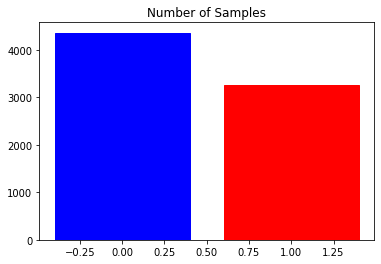

In [76]:
x = df.target.value_counts()
bar = plt.bar(x.index, x)
bar[0].set_color('b')
bar[1].set_color('r')
plt.title('Number of Samples')
plt.show()

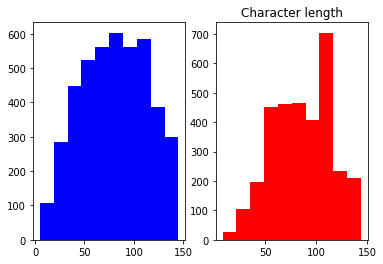

In [82]:
fig, a = plt.subplots(1,2)
dis = df[df.target==1].text.str.len()
xdis = df[df.target==0].text.str.len()
a[0].hist(xdis,color='b')
a[1].hist(dis,color='r')
plt.title('Character length')
plt.show()

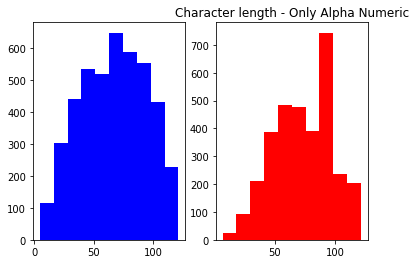

In [83]:
fig, a = plt.subplots(1,2)
dis = df[df.target==1].text.apply(lambda x: len([char for char in x if char.isalnum()]))
xdis = df[df.target==0].text.apply(lambda x: len([char for char in x if char.isalnum()]))
a[0].hist(xdis,color='b')
a[1].hist(dis,color='r')
plt.title('Character length - Only Alpha Numeric')
plt.show()

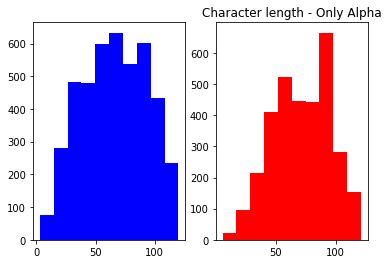

In [84]:
fig, a = plt.subplots(1,2)
dis = df[df.target==1].text.apply(lambda x: len([char for char in x if char.isalpha()]))
xdis = df[df.target==0].text.apply(lambda x: len([char for char in x if char.isalpha()]))
a[0].hist(xdis,color='b')
a[1].hist(dis,color='r')
plt.title('Character length - Only Alpha')
plt.show()

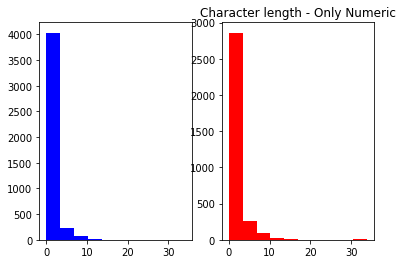

In [85]:
fig, a = plt.subplots(1,2)
dis = df[df.target==1].text.apply(lambda x: len([char for char in x if char.isnumeric()]))
xdis = df[df.target==0].text.apply(lambda x: len([char for char in x if char.isnumeric()]))
a[0].hist(xdis,color='b')
a[1].hist(dis,color='r')
plt.title('Character length - Only Numeric')
plt.show()

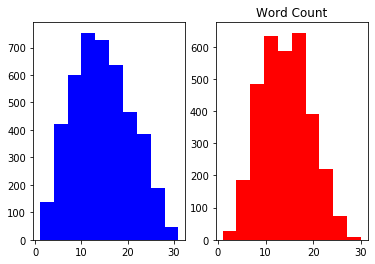

In [86]:
fig, a = plt.subplots(1,2)
dis = df[df.target==1].text.str.split().apply(lambda x: len(x))
xdis = df[df.target==0].text.str.split().apply(lambda x: len(x))
a[0].hist(xdis,color='b')
a[1].hist(dis,color='r')
plt.title('Word Count')
plt.show()

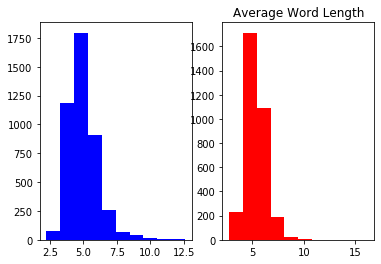

In [88]:
fig, a = plt.subplots(1,2)
dis = df[df.target==1].text.str.split().apply(lambda x: np.mean([len(word) for word in x]))
xdis = df[df.target==0].text.str.split().apply(lambda x: np.mean([len(word) for word in x]))
a[0].hist(xdis,color='b')
a[1].hist(dis,color='r')
plt.title('Average Word Length')
plt.show()

In [92]:
def create_corpus(df):
    corpus = []
    for row in tqdm(df['text']):
        word = [w.lower() for w in word_tokenize(row)] #if ((w.isalpha()) and (w not in stop)) ]
        corpus.append(word)
    return corpus

In [93]:
corpus0 = create_corpus(df.loc[df.target==0])
corpus1 = create_corpus(df.loc[df.target==1])

100%|████████████████████████████████████| 3255/3255 [00:00<00:00, 7091.50it/s]


In [138]:
stop0 = {}
stop1 = {}
for line in corpus0:
    for w in line:
        if w in stop:
            if w in stop0:
                stop0[w]+=1
            else:
                stop0[w]=0
for line in corpus1:
    for w in line:
        if w in stop:
            if w in stop1:
                stop1[w]+=1
            else:
                stop1[w]=0

In [144]:
liststop0 = sorted(stop0.items(), key=lambda x:x[1], reverse=True)
liststop1 = sorted(stop1.items(), key=lambda x:x[1], reverse=True)

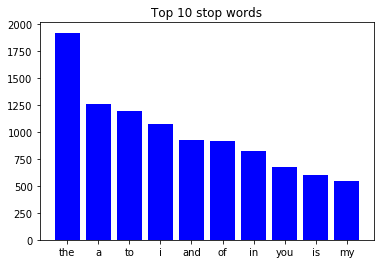

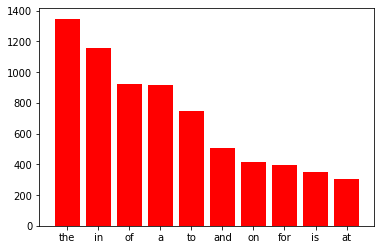

In [147]:
plt.title('Top 10 stop words')
x,y=zip(*liststop0[:10])
plt.bar(x,y,color='b')
plt.show()
x,y=zip(*liststop1[:10])
plt.bar(x,y,color='r')
plt.show()

In [183]:
xstop0 = {}
xstop1 = {}
for line in corpus0:
    for w in line:
        if w not in stop:
            if w in xstop0:
                xstop0[w]+=1
            else:
                xstop0[w]=0
for line in corpus1:
    for w in line:
        if w not in stop:
            if w in xstop1:
                xstop1[w]+=1
            else:
                xstop1[w]=0
listxstop0 = sorted(xstop0.items(), key=lambda x:x[1], reverse=True)
listxstop1 = sorted(xstop1.items(), key=lambda x:x[1], reverse=True)

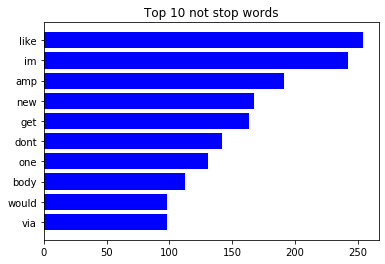

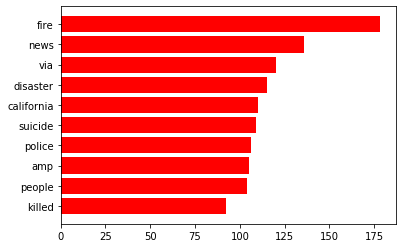

In [190]:
plt.title('Top 10 not stop words')
x,y=zip(*listxstop0[:10])
plt.barh(x,y,color='b')
plt.gca().invert_yaxis()
plt.show()
x,y=zip(*listxstop1[:10])
plt.barh(x,y,color='r')
plt.gca().invert_yaxis()
plt.show()

In [254]:
def get_bigram(corpus):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0,index]) for word, index in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq

In [255]:
bigram0 = get_bigram(df.loc[df.target==0,'text'])
bigram1 = get_bigram(df.loc[df.target==1,'text'])

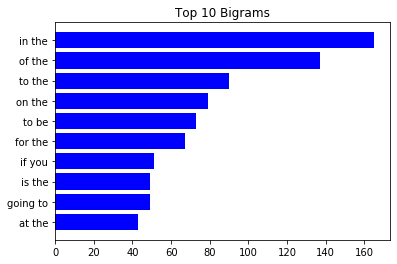

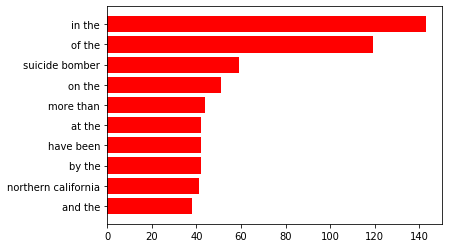

In [260]:
plt.title('Top 10 Bigrams')
x,y=zip(*bigram0[:10])
plt.barh(x,y,color='b')
plt.gca().invert_yaxis()
plt.show()
x,y=zip(*bigram1[:10])
plt.barh(x,y,color='r')
plt.gca().invert_yaxis()
plt.show()

In [261]:
df = pd.read_csv('train.csv')
punc0 = dict.fromkeys(string.punctuation,0)
corpuspunc0 = df.loc[df.target==0,'text'].apply(lambda x: [c for c in x if c in string.punctuation])
for line in corpuspunc0:
    if line:
        for c in line:
            punc0[c]+=1
            
punc1 = dict.fromkeys(string.punctuation,0)
corpuspunc1 = df.loc[df.target==1,'text'].apply(lambda x: [c for c in x if c in string.punctuation])
for line in corpuspunc1:
    if line:
        for c in line:
            punc1[c]+=1

In [262]:
listpunc0 = sorted(punc0.items(), key=lambda x:x[1], reverse=True)
listpunc1 = sorted(punc1.items(), key=lambda x:x[1], reverse=True)

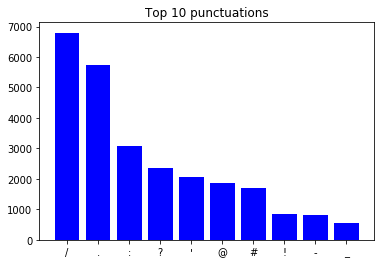

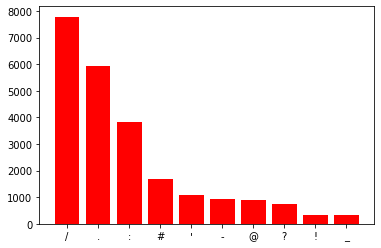

In [264]:
plt.title('Top 10 punctuations')
x,y=zip(*listpunc0[:10])
plt.bar(x,y,color='b')
plt.show()
x,y=zip(*listpunc1[:10])
plt.bar(x,y,color='r')
plt.show()